In [182]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df=pd.read_csv("PGCB_Demand_Data_2021.csv")
df["DateTime"] = pd.to_datetime(df.date.astype(str) + ' ' + df.hour.astype(str), format='%m/%d/%Y %H')
df["DateTime"]=pd.to_datetime(df["DateTime"])
df.set_index("DateTime",inplace=True)
df

,date,year,month,day,weekday,hour,demand
DateTime,,,,,,,
2018-01-01 00:00:00,1/1/2018,2018,1,1,2,0,5673.00
2018-01-01 01:00:00,1/1/2018,2018,1,1,2,1,5183.00
2018-01-01 02:00:00,1/1/2018,2018,1,1,2,2,4908.00
2018-01-01 03:00:00,1/1/2018,2018,1,1,2,3,4786.00
2018-01-01 04:00:00,1/1/2018,2018,1,1,2,4,4599.00
...,...,...,...,...,...,...,...
2021-03-15 19:00:00,3/15/2021,2021,3,15,2,19,10321.02
2021-03-15 20:00:00,3/15/2021,2021,3,15,2,20,11242.00
2021-03-15 21:00:00,3/15/2021,2021,3,15,2,21,10994.12


In [3]:
df.shape

(28080, 7)

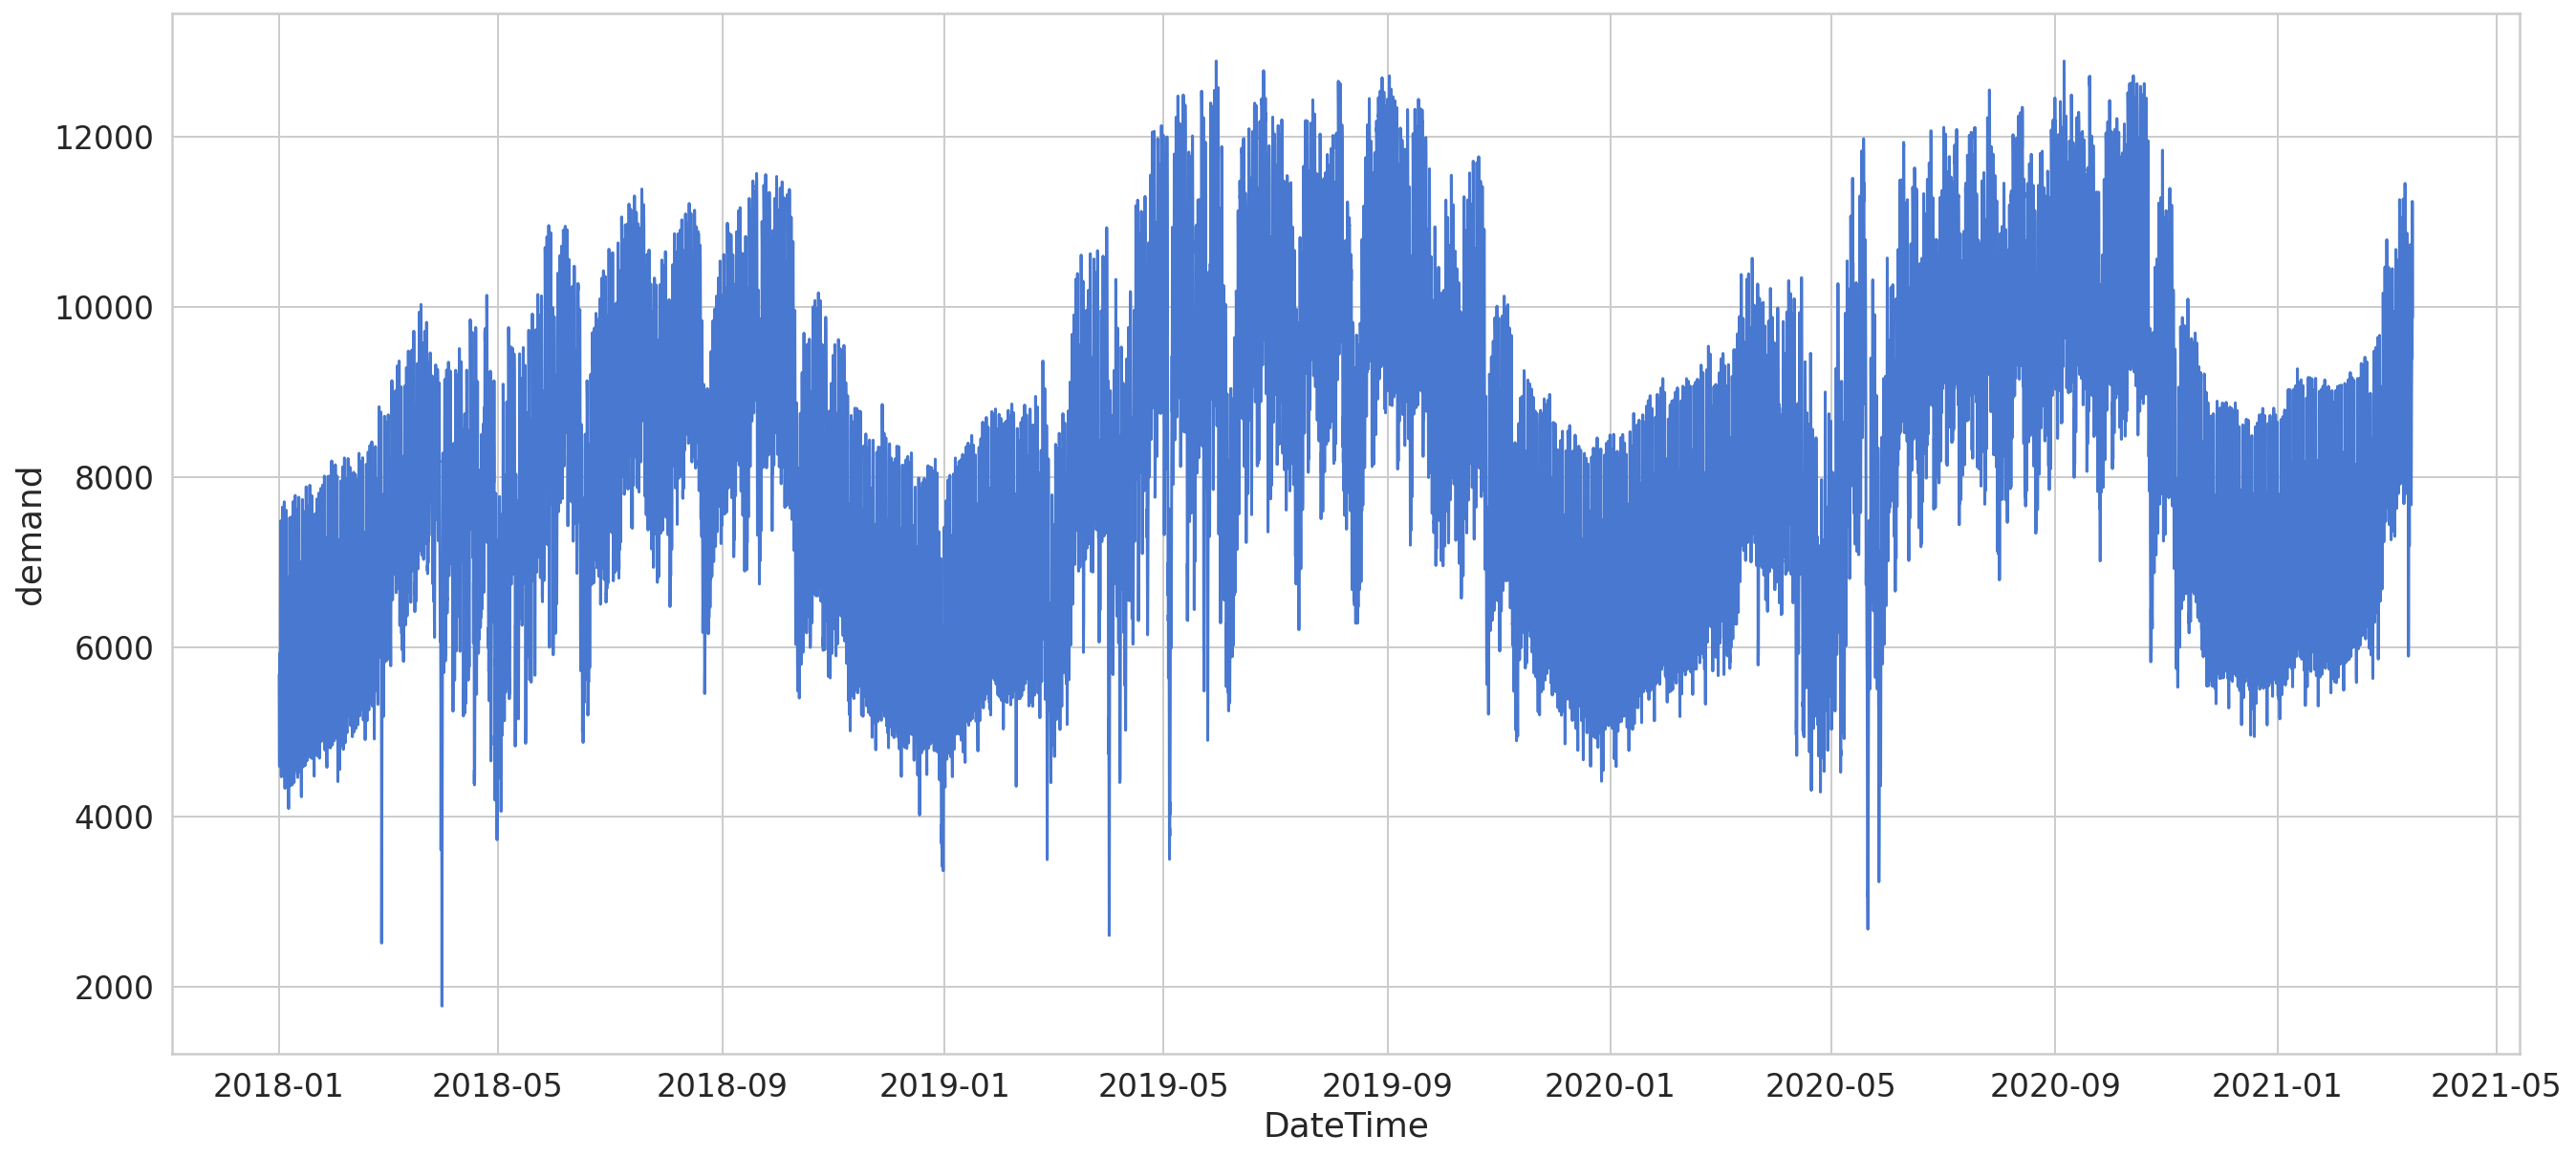

In [4]:
sns.lineplot(x=df.index, y="demand", data=df);

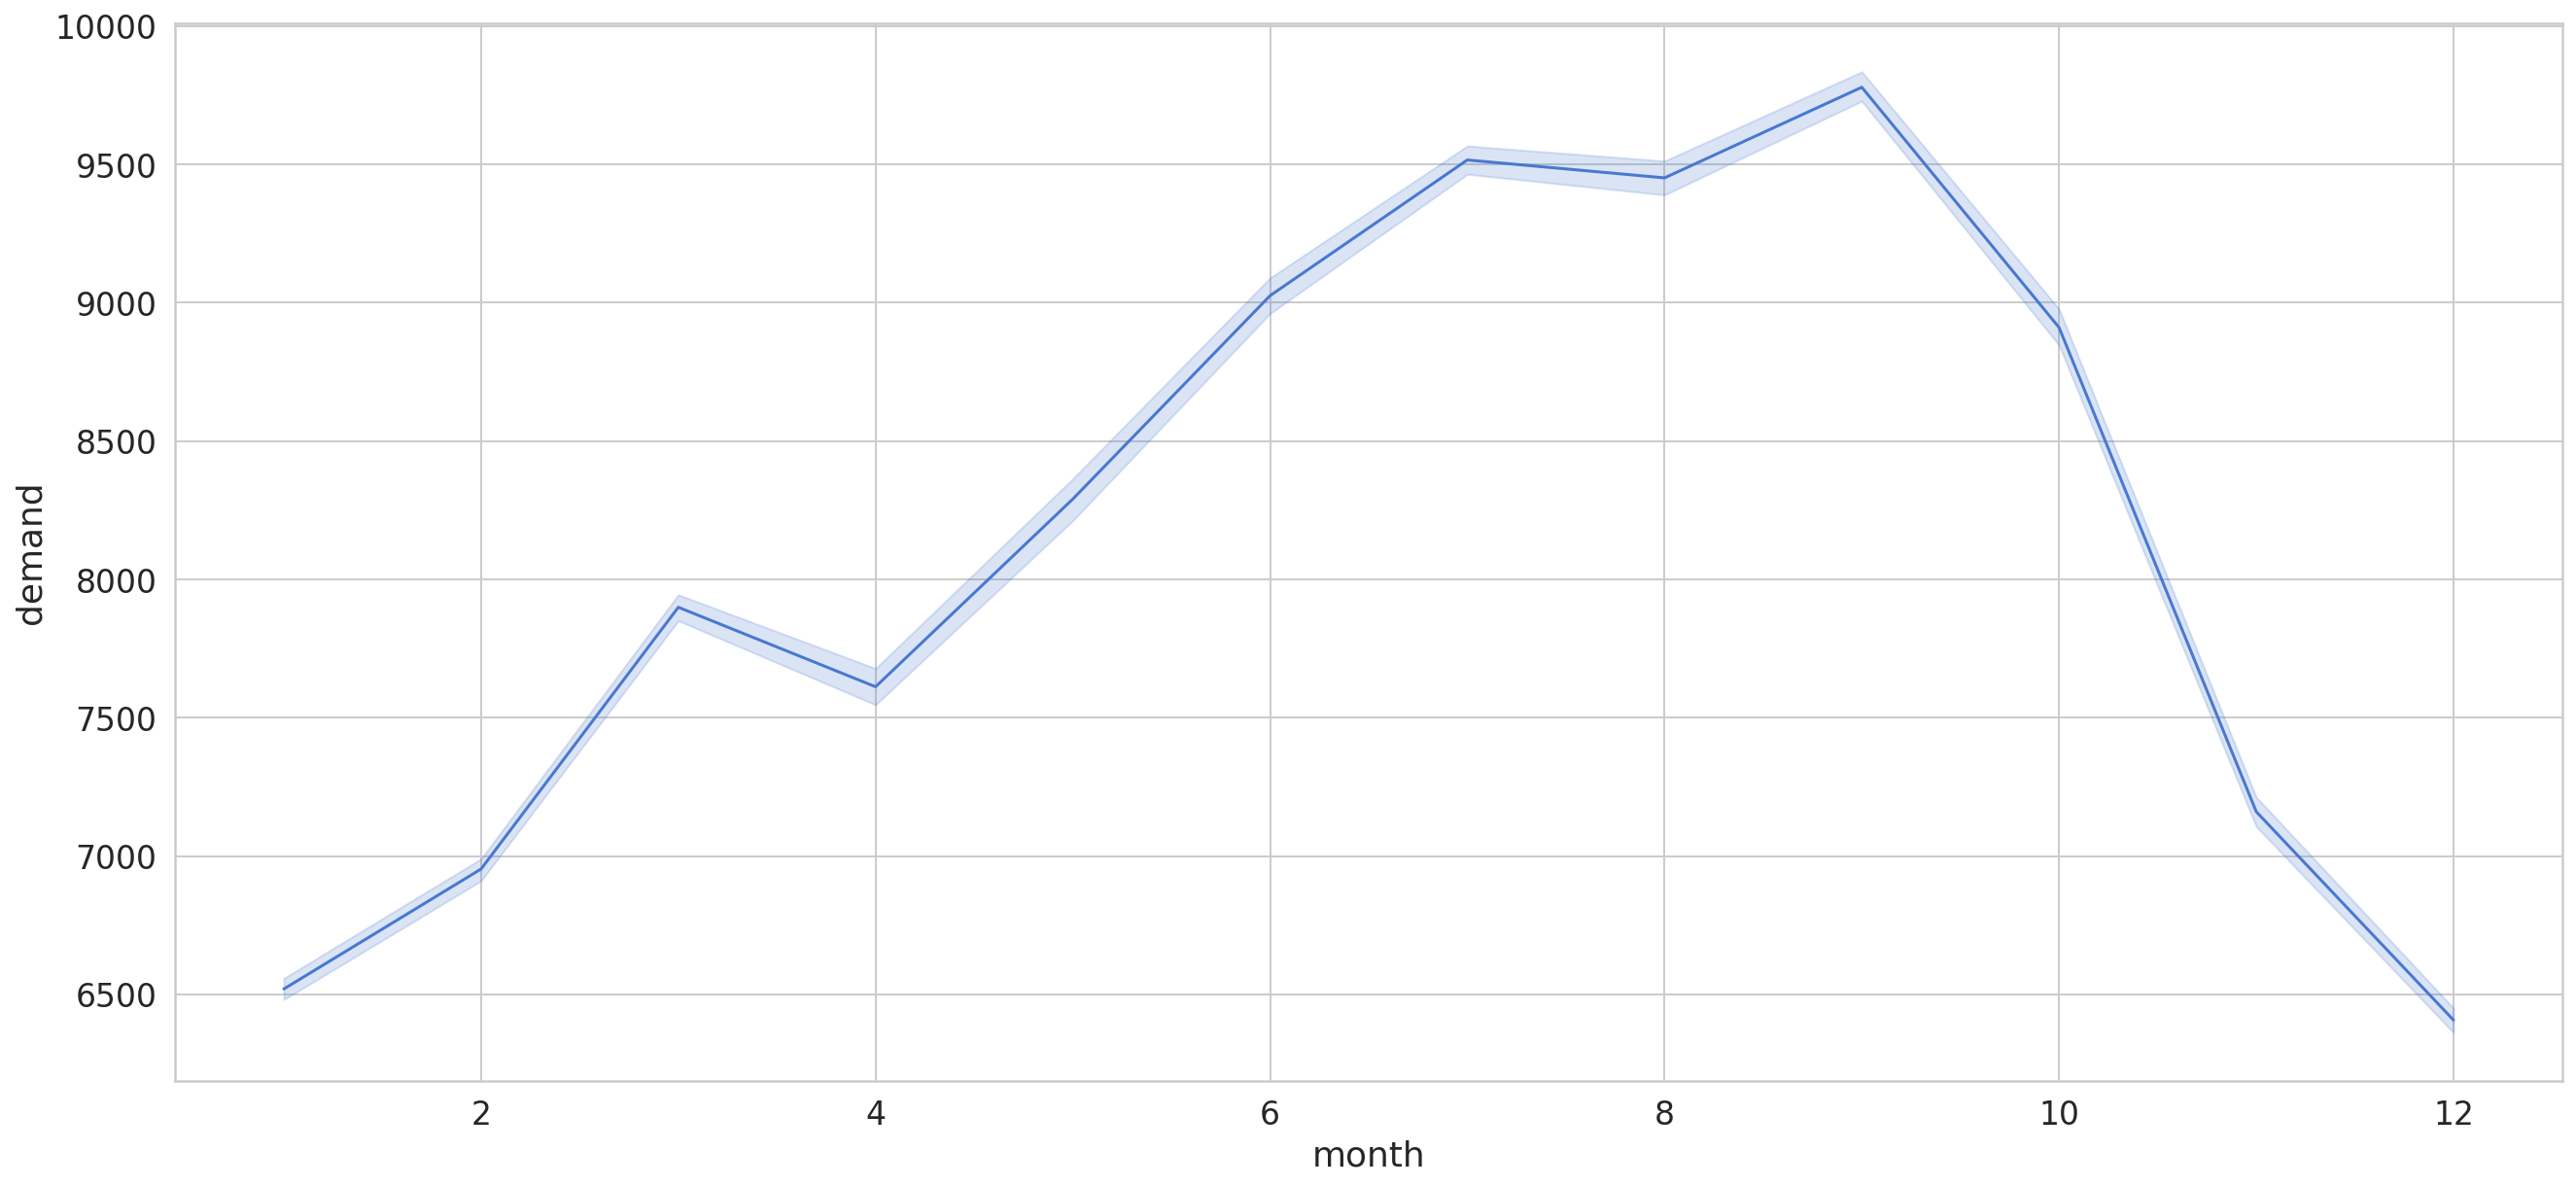

In [5]:
sns.lineplot(x='month', y="demand", data=df);

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed=seasonal_decompose(df["demand"],
                             model='additive'
                             )

In [7]:
trend=decomposed.trend
sesonal=decomposed.seasonal
residual=decomposed.resid

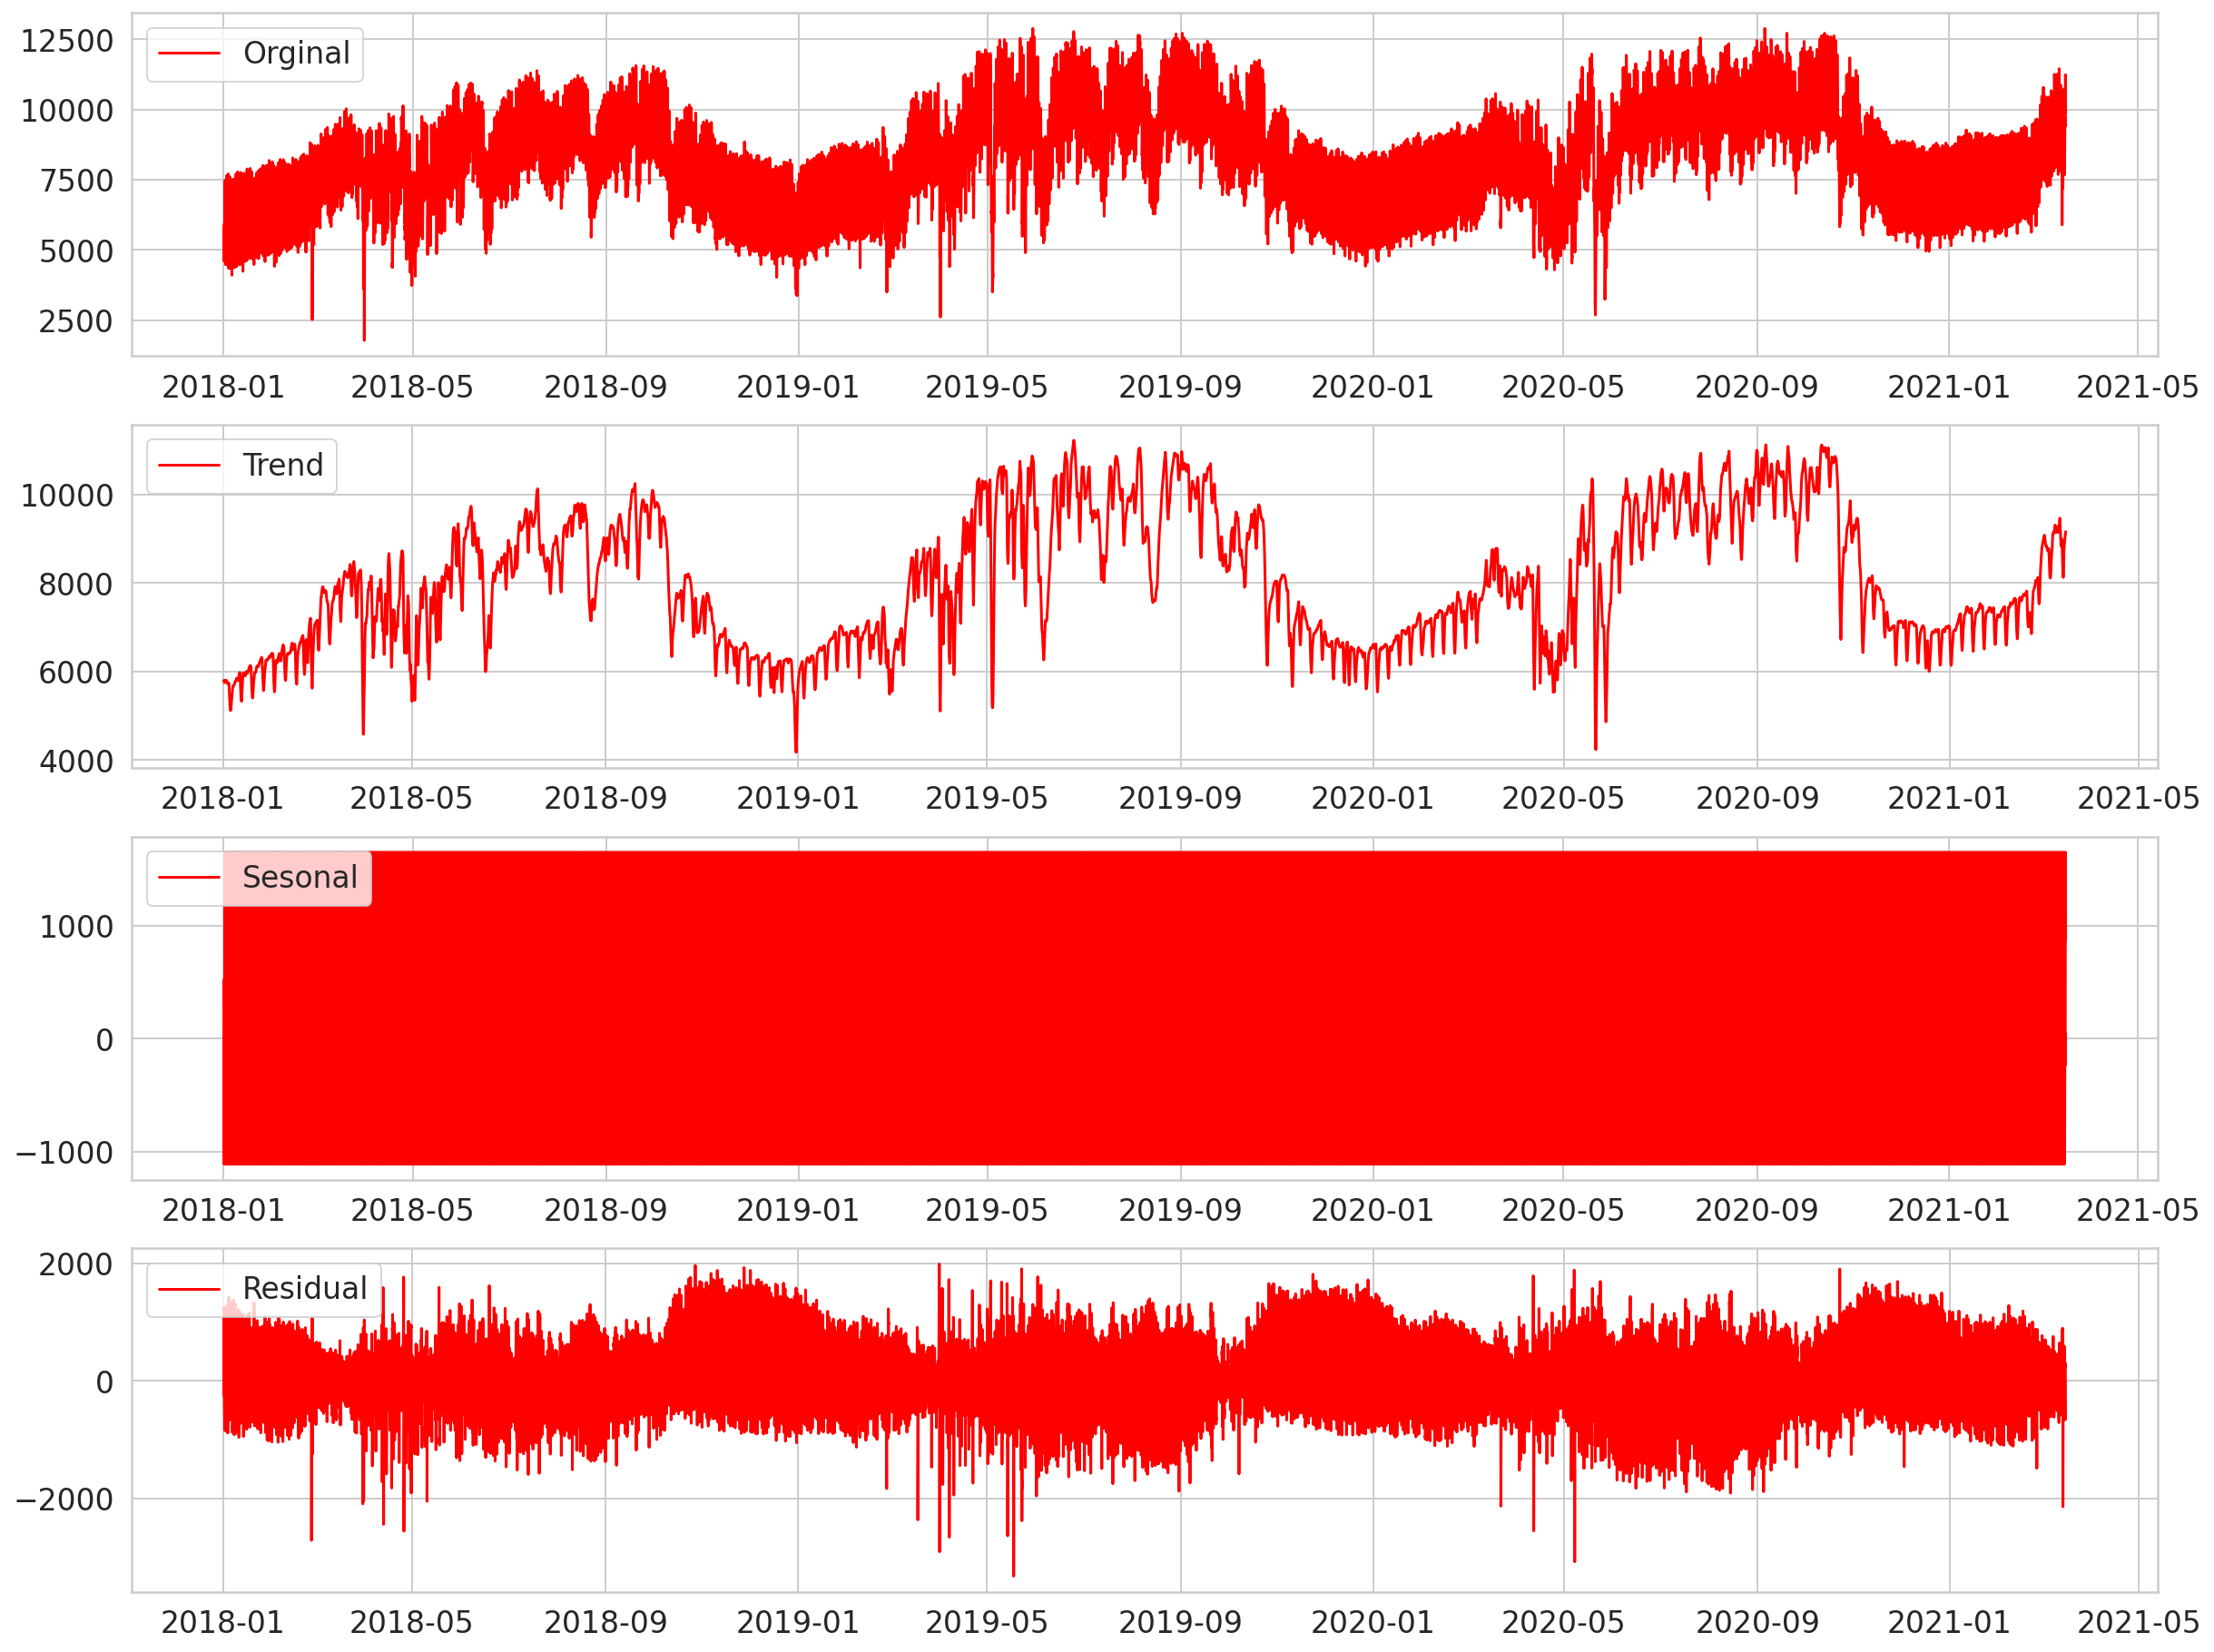

In [8]:
plt.figure(figsize=(20,16))
plt.subplot(411)
plt.plot(df["demand"],label="Orginal",color='red')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label="Trend",color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(sesonal,label="Sesonal",color='red')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual,label="Residual",color='red')
plt.legend(loc='upper left')
plt.show()

In [9]:
# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler(feature_range=(0,1))
# X=scaler.fit_transform(df.demand.values.reshape(-1,1))
D_max_daily = df.groupby(df.index).demand.max().to_numpy()
df.demand= df.demand/max(D_max_daily)
D_max=max(D_max_daily)

In [10]:
##splitting dataset into train and test split
training_size=int(len(df)*0.65)
test_size=len(df)-training_size
train_data,test_data=df.demand[0:training_size],df.demand[training_size:len(df)]

In [11]:
train=train_data.values.reshape(-1,1)
test=test_data.values.reshape(-1,1)

In [12]:
train.shape

(18252, 1)

In [13]:
test.shape

(9828, 1)

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [15]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 24*7 # take time laps for 7 days
X_train, y_train = create_dataset(train, time_step)
X_test, ytest = create_dataset(test, time_step)

In [16]:
print(X_train.shape)
print(y_train.shape)

(18083, 168)
(18083,)


In [17]:
print(X_test.shape)
print(ytest.shape)

(9659, 168)
(9659,)


In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
print(X_train.shape)
print(y_train.shape)

(18083, 168, 1)
(18083,)


In [20]:
X_train

array([[[0.4400062 ],
        [0.40200109],
        [0.38067168],
        ...,
        [0.55247033],
        [0.50888079],
        [0.45559606]],

       [[0.40200109],
        [0.38067168],
        [0.37120918],
        ...,
        [0.50888079],
        [0.45559606],
        [0.41503141]],

       [[0.38067168],
        [0.37120918],
        [0.35670519],
        ...,
        [0.45559606],
        [0.41503141],
        [0.37702629]],

       ...,

       [[0.45280385],
        [0.46622198],
        [0.45365702],
        ...,
        [0.43915303],
        [0.45094237],
        [0.47925231]],

       [[0.46622198],
        [0.45365702],
        [0.44791747],
        ...,
        [0.45094237],
        [0.47925231],
        [0.50042659]],

       [[0.45365702],
        [0.44791747],
        [0.46342977],
        ...,
        [0.47925231],
        [0.50042659],
        [0.51826573]]])

In [21]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional,GRU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard

from keras.layers import TimeDistributed


In [28]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_absolute_percentage_error',optimizer='adam')

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 168, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 168, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [30]:
import time
start_time = time.time()
history=model.fit(X_train,y_train,epochs=30,batch_size=64,validation_split=0.2)
finish_time = time.time()
print("--- %s seconds ---" % (finish_time - start_time))

Epoch 1/30
227/227 [==============================] - 77s 340ms/step - loss: 14.4501 - val_loss: 11.5912
Epoch 2/30
227/227 [==============================] - 79s 348ms/step - loss: 9.2510 - val_loss: 6.9048
Epoch 3/30
227/227 [==============================] - 80s 353ms/step - loss: 7.0144 - val_loss: 8.0659
Epoch 4/30
227/227 [==============================] - 73s 320ms/step - loss: 6.1442 - val_loss: 5.5349
Epoch 5/30
227/227 [==============================] - 78s 344ms/step - loss: 5.8158 - val_loss: 5.7752
Epoch 6/30
227/227 [==============================] - 68s 301ms/step - loss: 5.1869 - val_loss: 7.4632
Epoch 7/30
227/227 [==============================] - 77s 341ms/step - loss: 4.5972 - val_loss: 5.1727
Epoch 8/30
227/227 [==============================] - 69s 305ms/step - loss: 4.0488 - val_loss: 3.3078
Epoch 9/30
227/227 [==============================] - 96s 421ms/step - loss: 3.3133 - val_loss: 2.6365
Epoch 10/30
227/227 [==============================] - 71s 315ms/step -

In [31]:
print((finish_time - start_time)/60,'minutes')
scores = model.evaluate(X_test, ytest)
print("TEST MAPE :",scores)

39.23070997794469 minutes
302/302 [==============================] - 15s 50ms/step - loss: 2.5522
TEST MAPE : 2.55216383934021


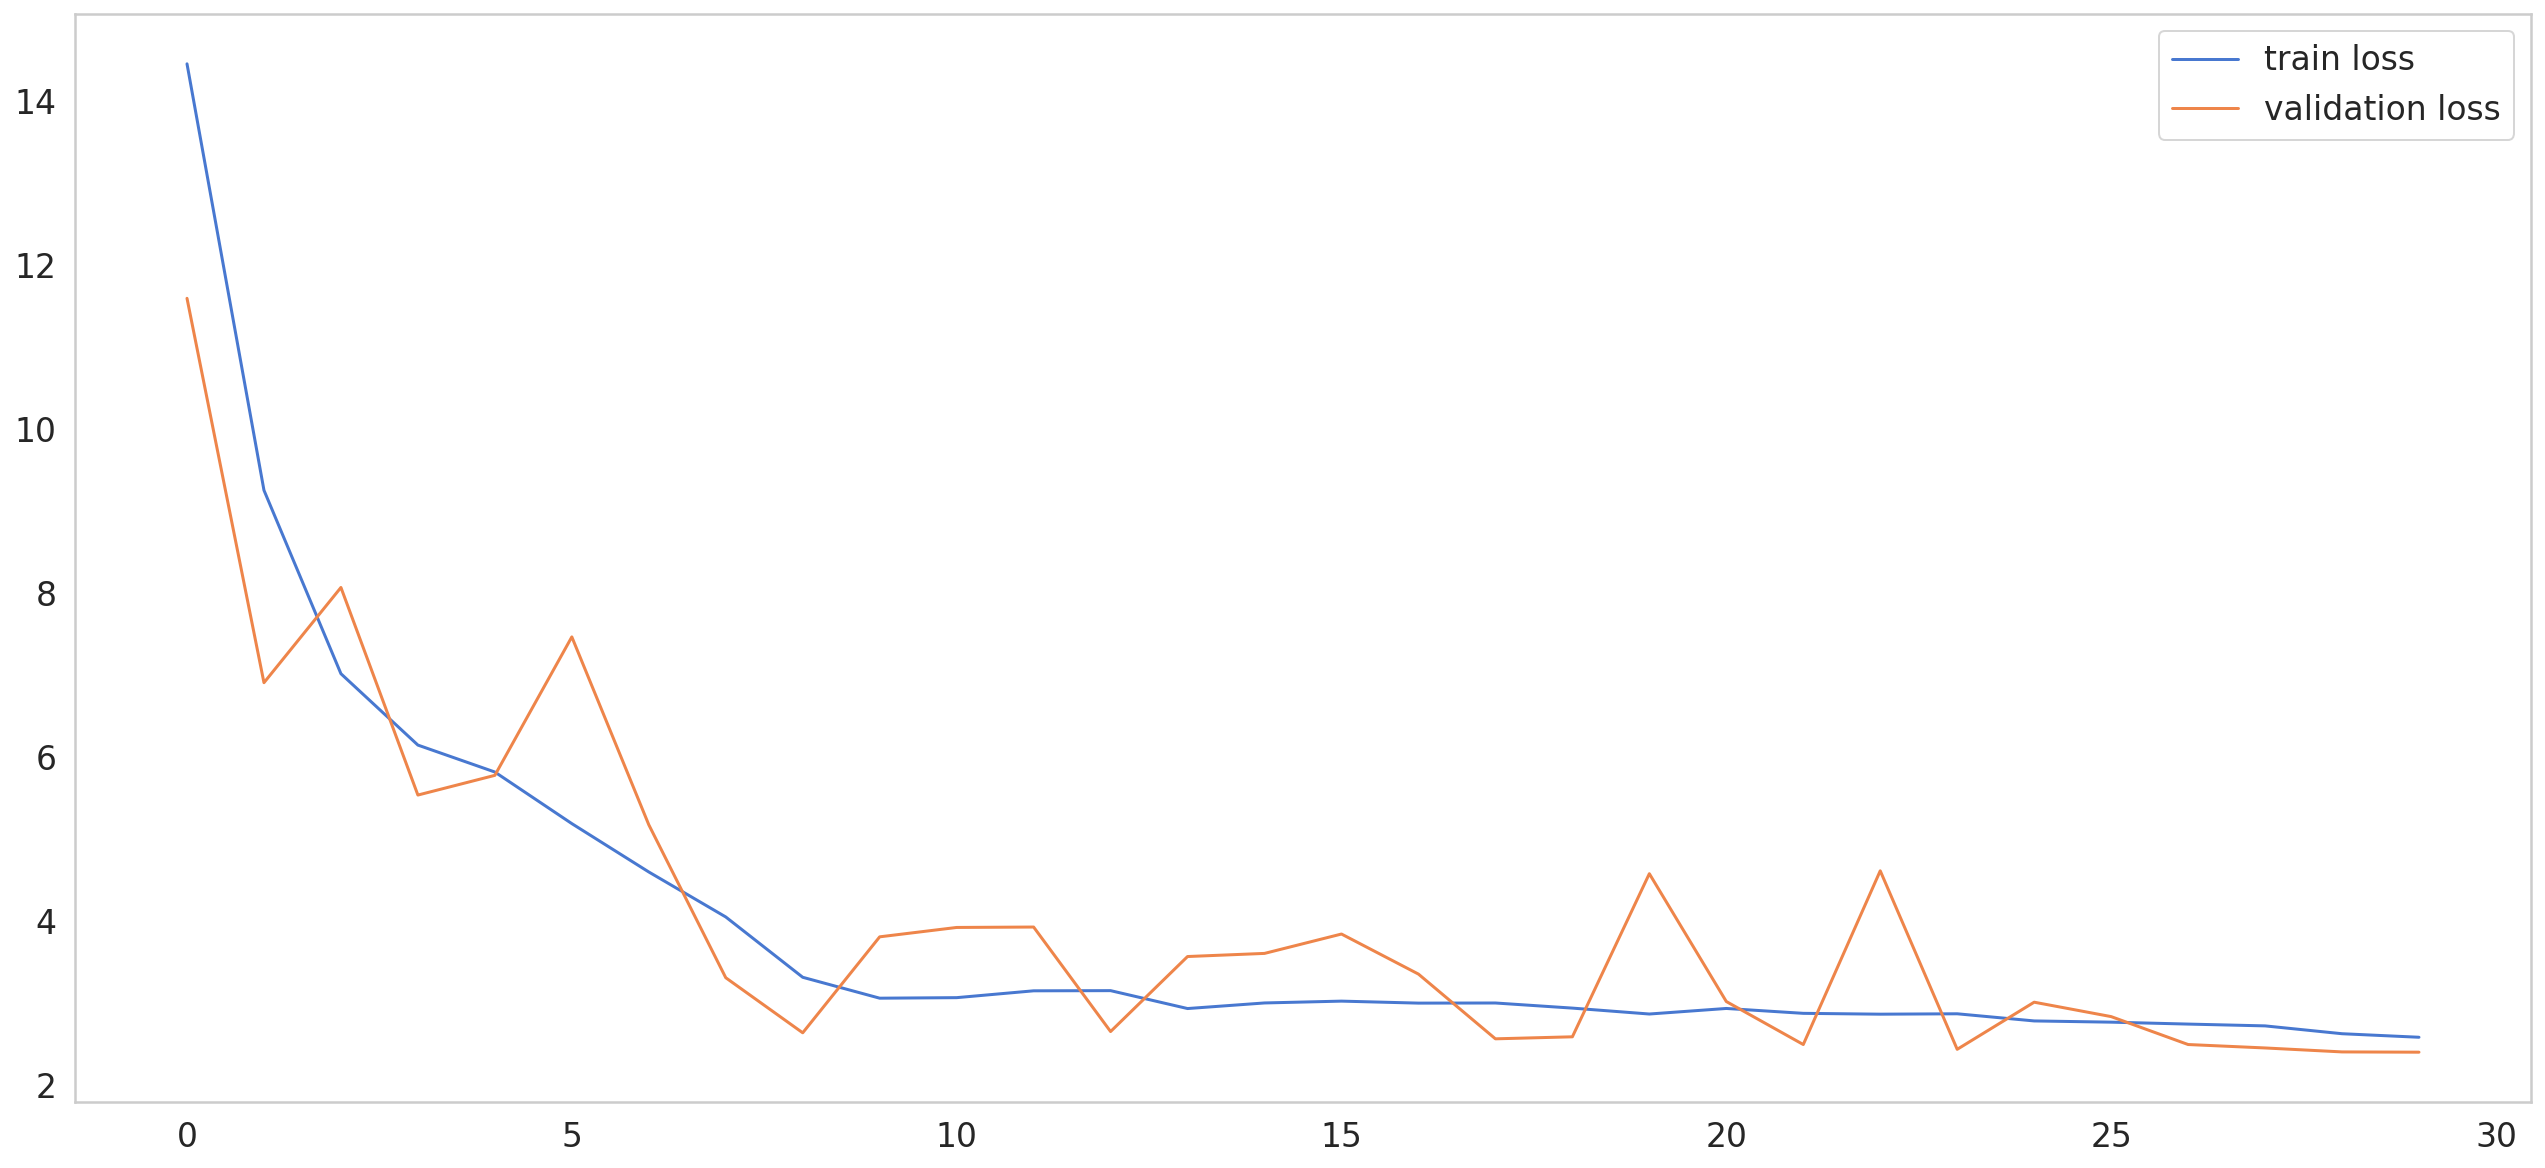

In [183]:
import matplotlib.pyplot as plta

plta.plot(history.history['loss'])
plta.plot(history.history['val_loss'])
plta.grid(False)
plt.legend(['train loss','validation loss'])
plta.show()

In [35]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [36]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train*D_max,train_predict*D_max))

292.1186645316897

In [37]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest*D_max,test_predict*D_max))

299.12209489028396

In [38]:
train_predict.shape

(18083, 1)

In [39]:
y_train_rs=y_train.reshape(-1,1)
y_train_rs.shape

(18083, 1)

In [40]:
df.demand.shape

(28080,)

In [41]:
train_predict.shape

(18083, 1)

In [42]:
test_predict.shape

(9659, 1)

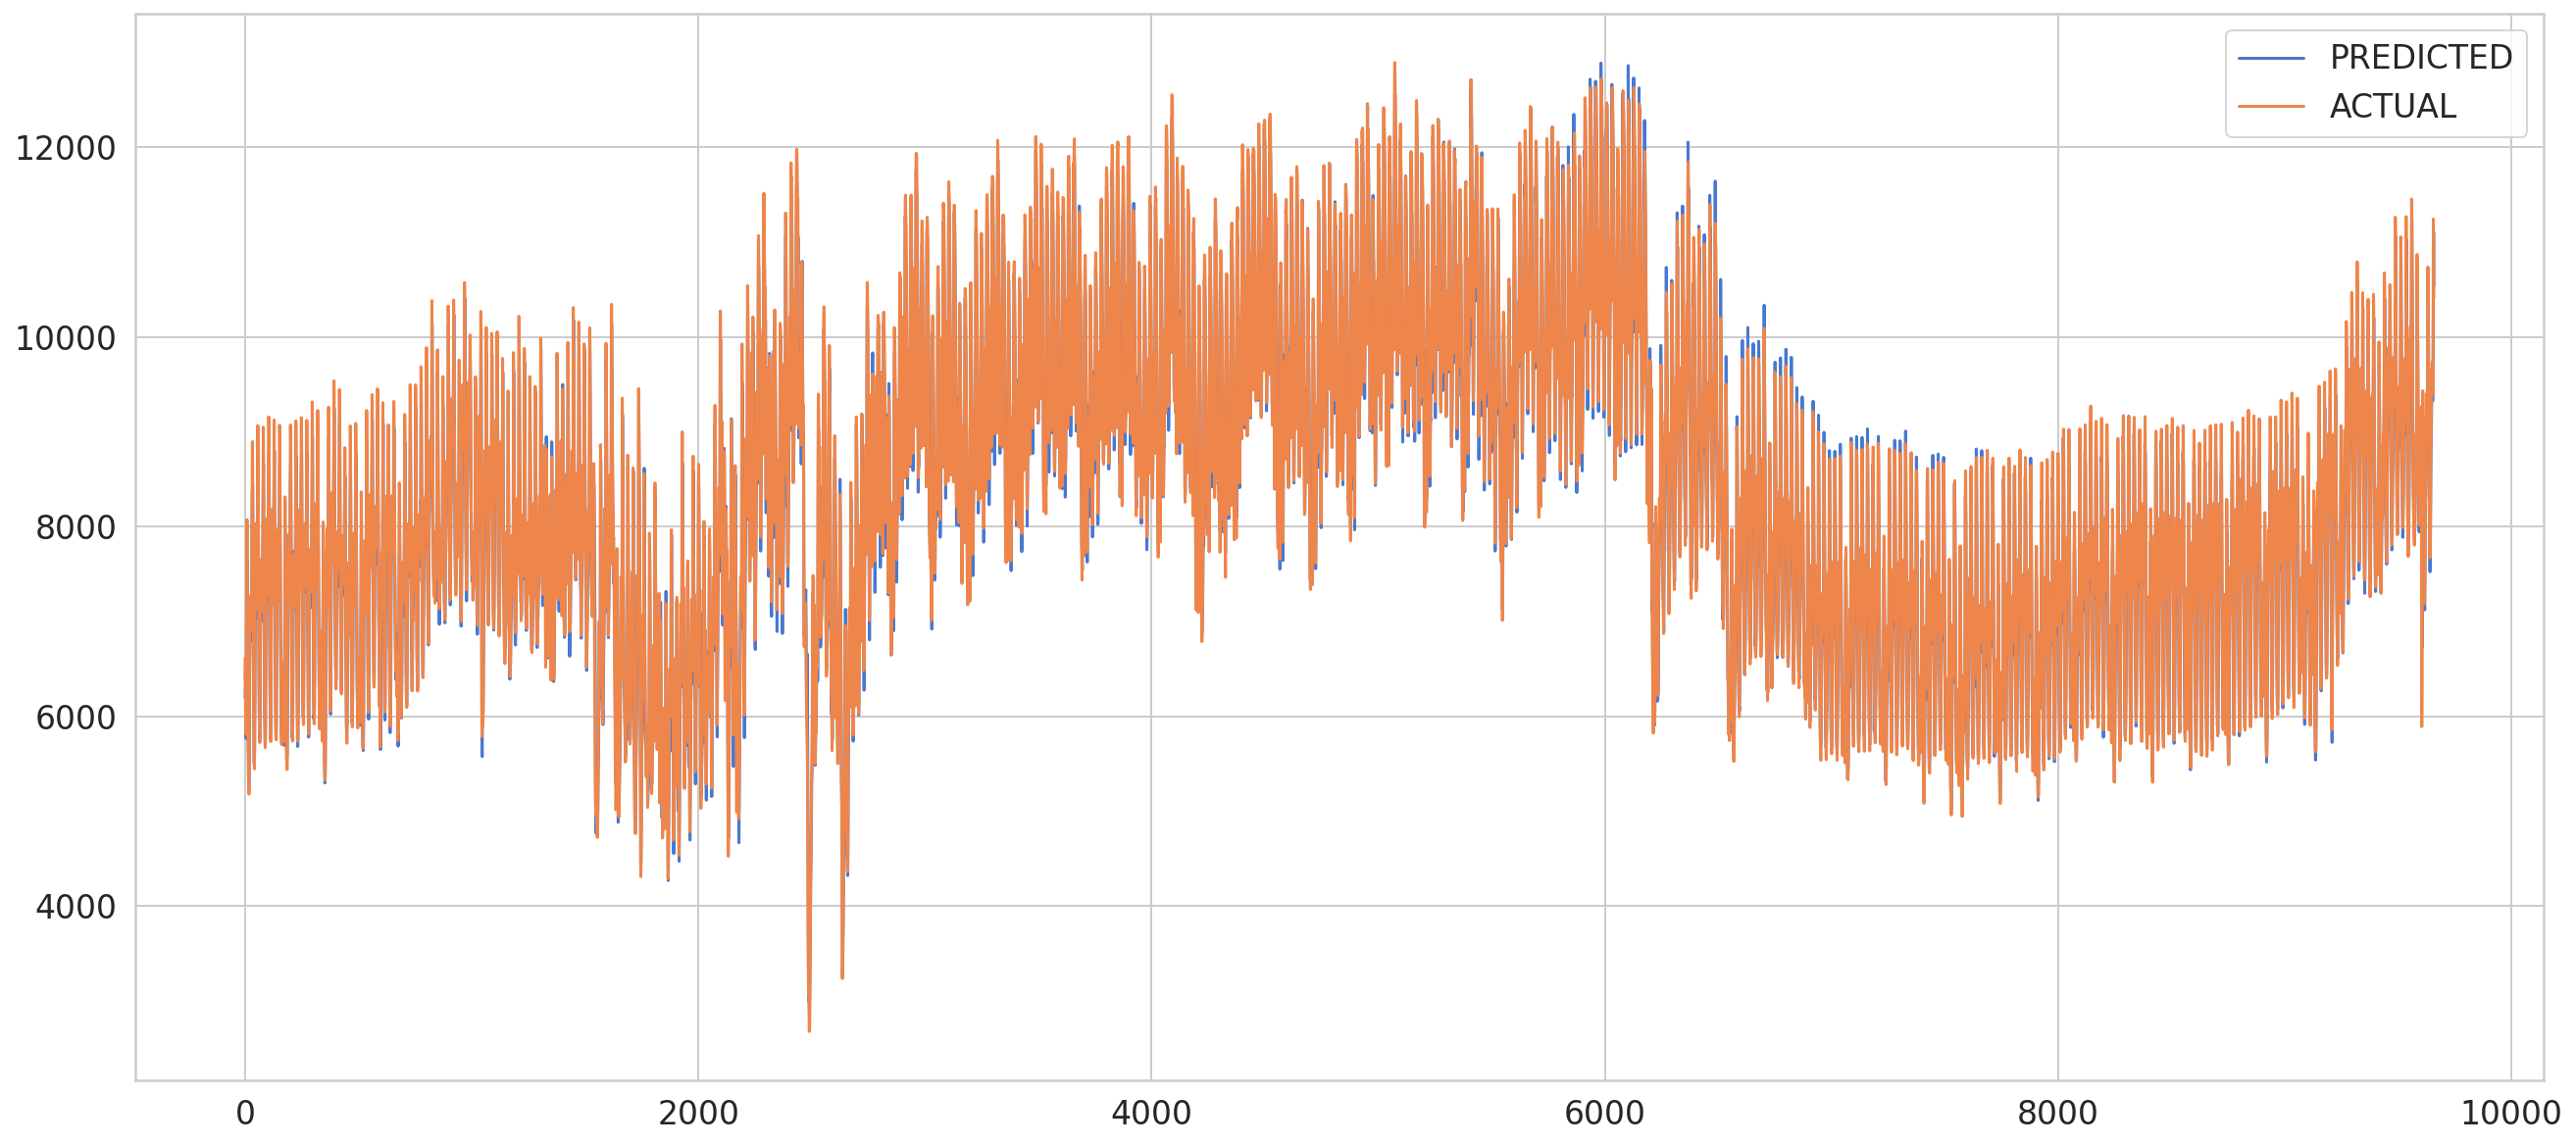

In [167]:
plt.plot(test_predict*D_max)
plt.plot(ytest*D_max)
plt.legend(['PREDICTED','ACTUAL'])

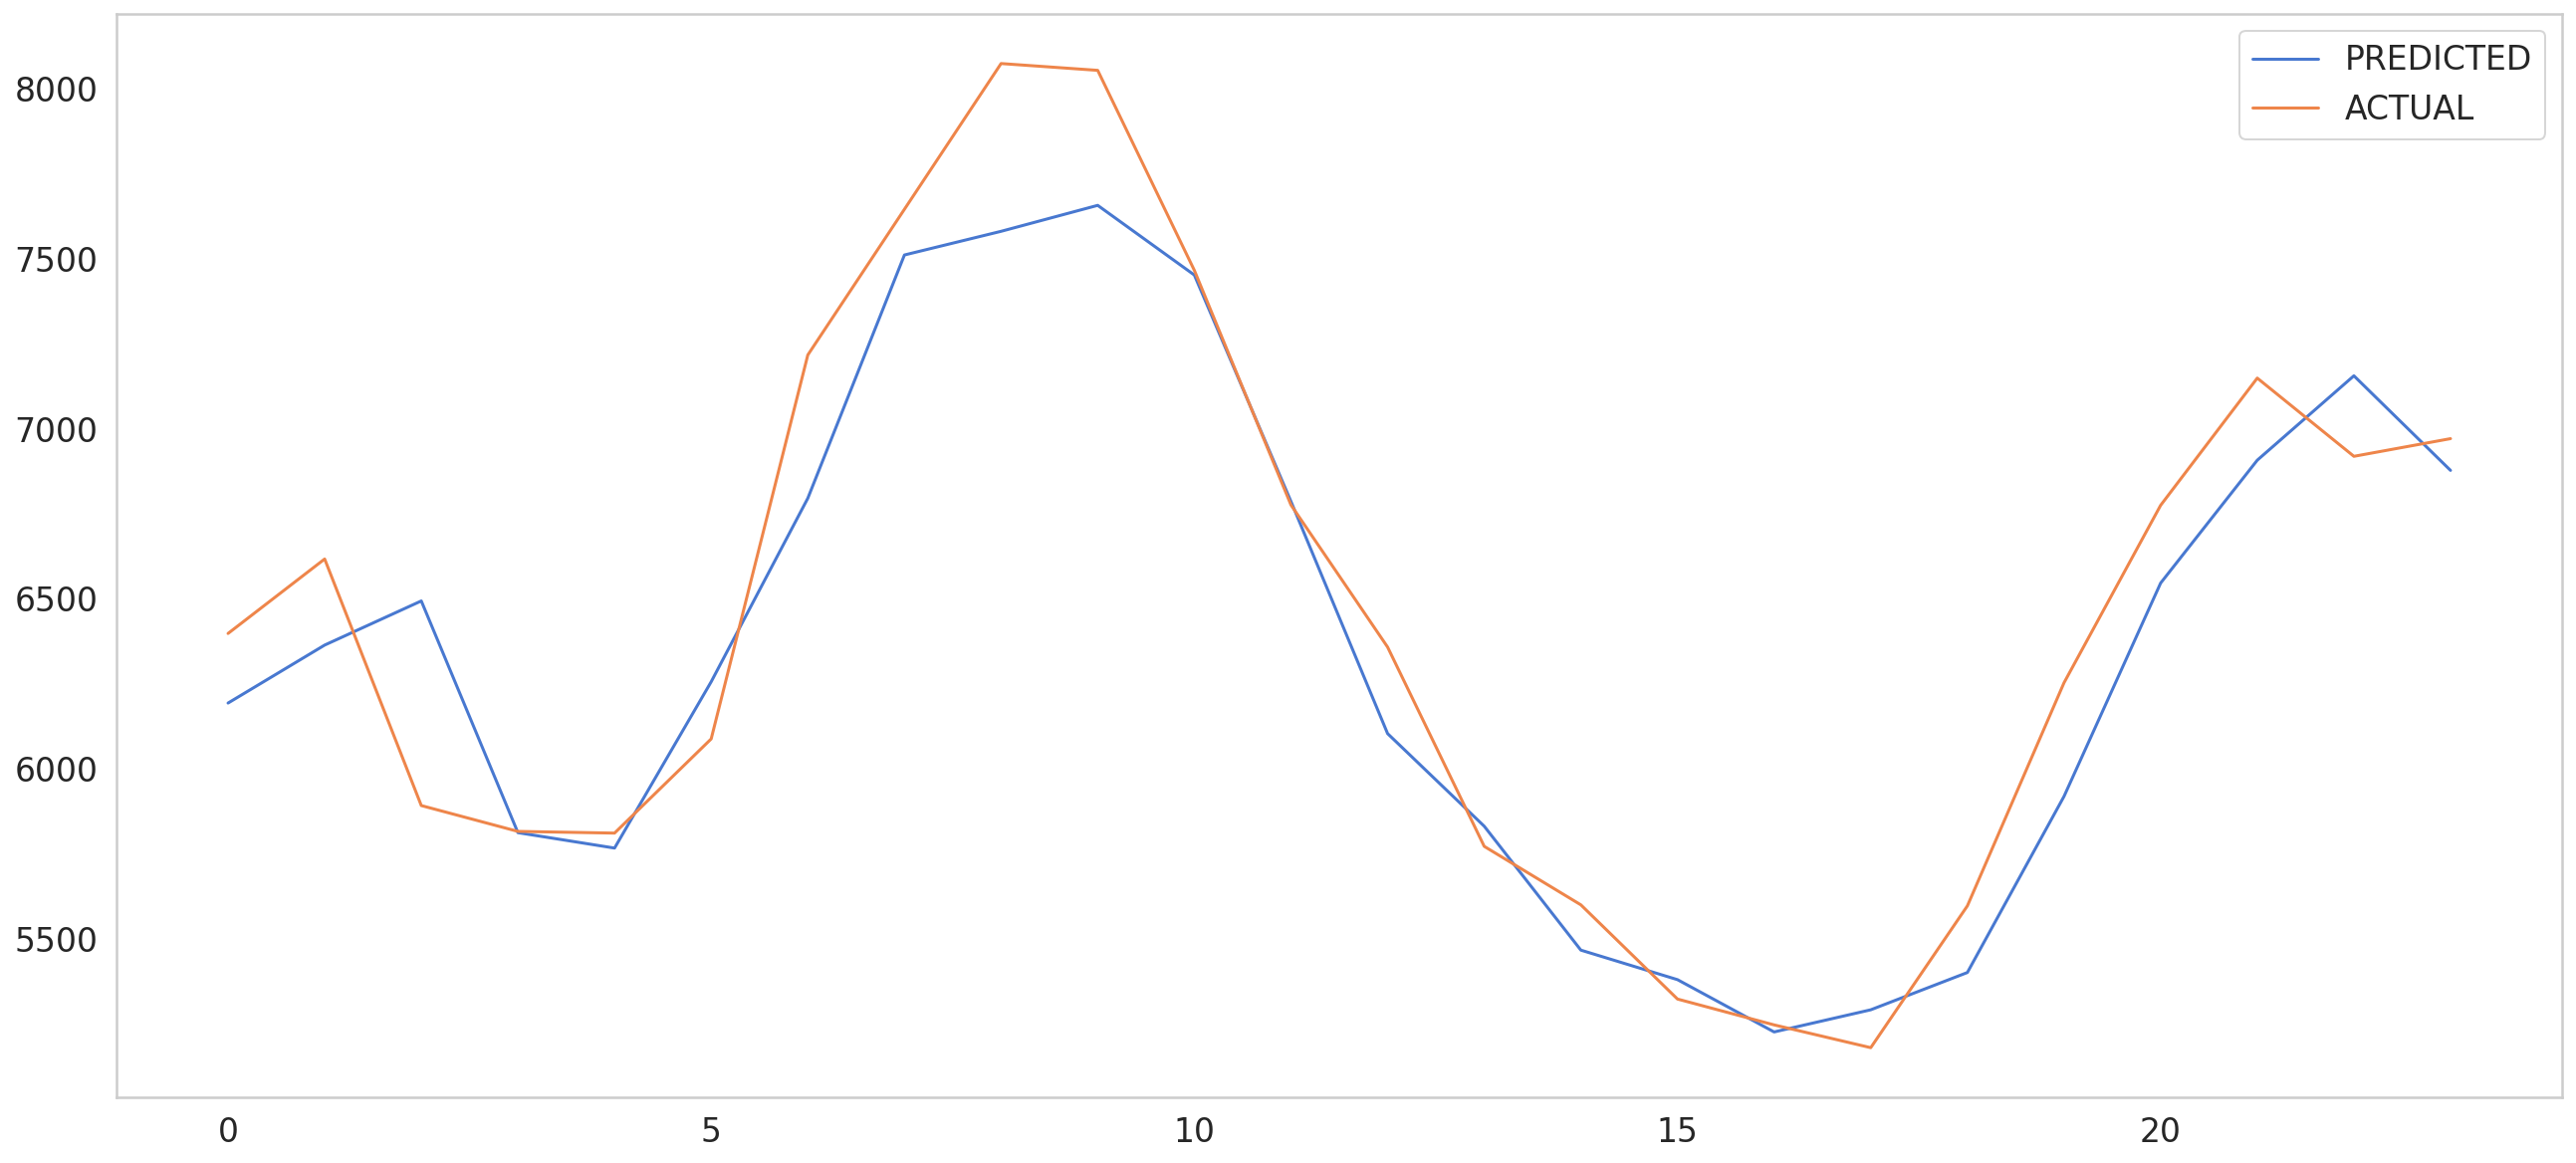

In [184]:
plt.plot(test_predict[:24]*D_max)
plt.plot(ytest[:24]*D_max)
plt.grid(False)
plt.legend(['PREDICTED','ACTUAL'])


In [117]:
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))

In [193]:
from sklearn.ensemble import RandomForestRegressor
cls = RandomForestRegressor(n_estimators=1,min_samples_leaf=100)
cls.fit(d2_train_dataset,y_train)

RandomForestRegressor(min_samples_leaf=100, n_estimators=1)

In [194]:
nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))

In [195]:
sk_pred=cls.predict(d2_test_dataset)

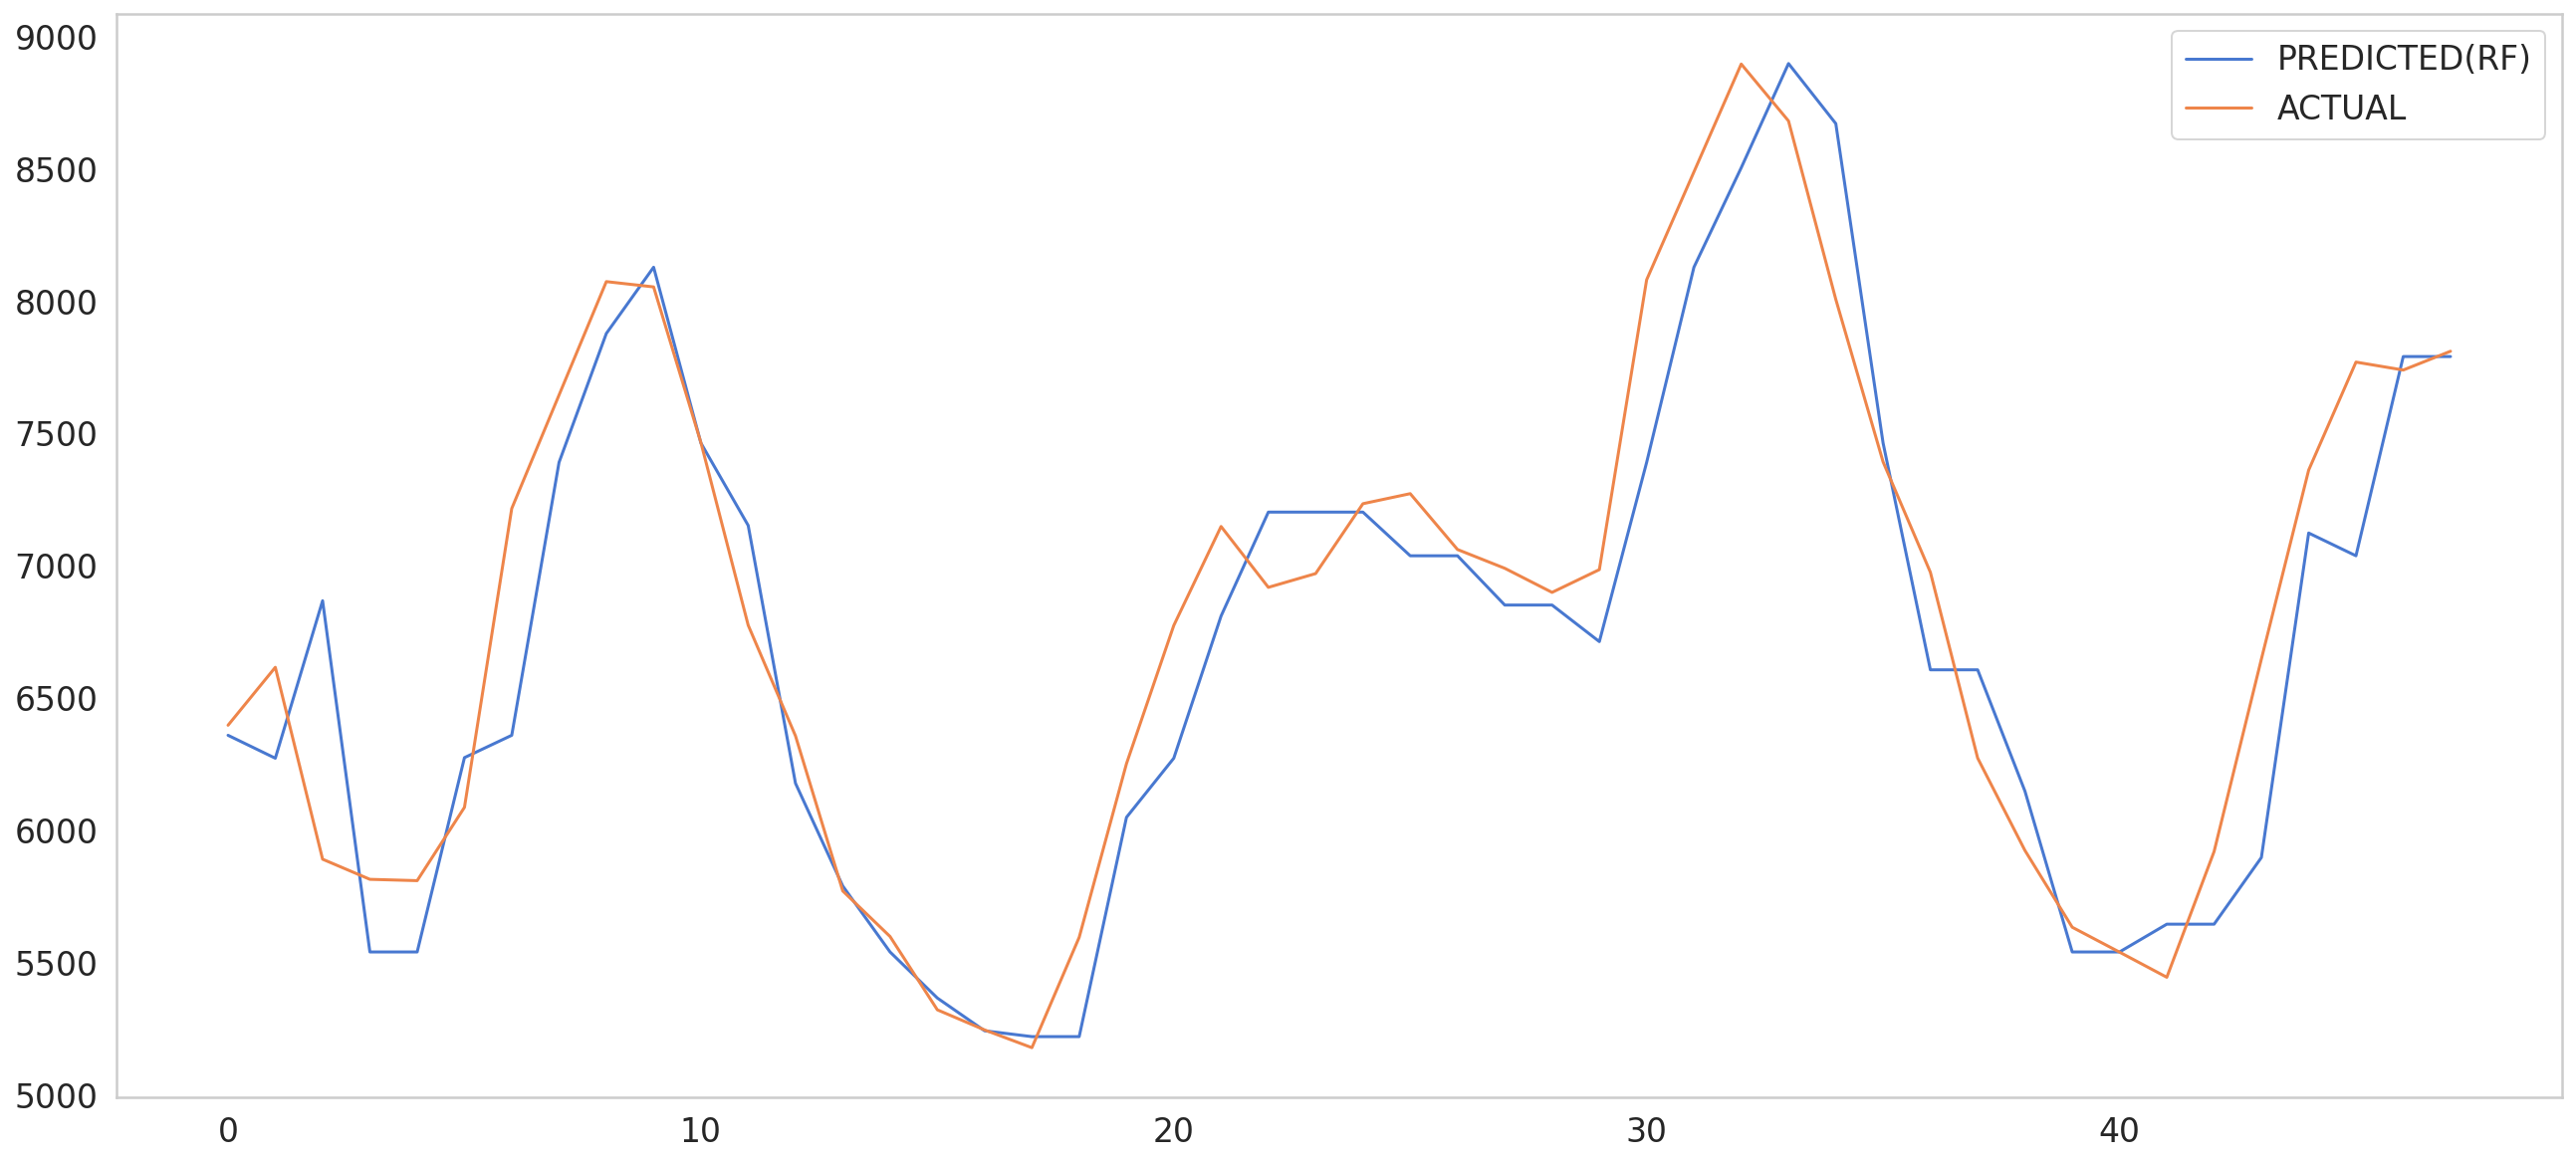

In [196]:
plt.plot(sk_pred[0:48]*D_max)
plt.plot(ytest[0:48]*D_max)
plt.grid(False)

plt.legend(['PREDICTED(RF)','ACTUAL'])

In [197]:
import sklearn.metrics
from sklearn.metrics import mean_squared_error

In [198]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [199]:
MAPE_RF=mean_absolute_percentage_error(ytest,sk_pred)
MAPE_RF

3.353819941404491

In [200]:
cls.score(d2_test_dataset,ytest)

0.9536063517271872